1. 더미 데이터 불러오기

In [4]:
import pandas as pd

# 필요한 컬럼만 선택하여 CSV 읽기
selected_columns = [
    "시도명", "시군구명"
]

df = pd.read_csv("./data/소상공인시장진흥공단_상가(상권)정보_경남_202503.csv", 
                 usecols=selected_columns).fillna("")

# 시군구별 데이터 개수 집계
city_counts = df["시군구명"].value_counts().sort_values(ascending=False)
print("경남 시/군별 상가 데이터 개수:")
print(city_counts)

경남 시/군별 상가 데이터 개수:
시군구명
김해시          26565
진주시          19254
양산시          16324
창원시 성산구      13519
거제시          12317
창원시 의창구      11093
창원시 마산합포구     9869
창원시 진해구       8428
창원시 마산회원구     8283
통영시           7385
사천시           6405
밀양시           5737
거창군           3341
남해군           3212
창녕군           3156
함안군           2939
하동군           2856
고성군           2647
함양군           2123
산청군           1995
합천군           1946
의령군           1074
Name: count, dtype: int64


In [2]:
import pandas as pd

# 필요한 컬럼만 선택하여 CSV 읽기 (상위 100줄만)
selected_columns = [
    "상권업종대분류코드", "상권업종대분류명", "상권업종중분류코드", "상권업종중분류명", 
    "상권업종소분류코드", "상권업종소분류명", "시도코드", "시도명", "시군구코드", "시군구명", 
    "행정동코드", "행정동명", "법정동명", "지번주소", "도로명주소", "경도", "위도"
]

df = pd.read_csv("./data/소상공인시장진흥공단_상가(상권)정보_경남_202503.csv", 
                 usecols=selected_columns,
                 #nrows=10000
                 ).fillna("")

# 시군구명이 "남해군"인 데이터만 필터링
cityname = "창녕군"
df = df[df["시군구명"] == cityname].reset_index(drop=True)

print(f"{cityname} 데이터 수: {len(df)}개")
print(f"\n{cityname} 내 시군구별 분포:")
print(df["시군구명"].value_counts())

# 텍스트 컬럼 생성 (주소 정보를 결합)
df["text"] = (df["시도명"].str.strip() + " " + 
              df["시군구명"].str.strip() + " " + 
              df["행정동명"].str.strip() + " " + 
              df["상권업종대분류명"].str.strip() + " " + 
              df["상권업종중분류명"].str.strip() + " " + 
              df["상권업종소분류명"].str.strip())

print(f"\n=== {cityname} 상가 데이터 샘플 ===")

print(df.head(2))

창녕군 데이터 수: 3156개

창녕군 내 시군구별 분포:
시군구명
창녕군    3156
Name: count, dtype: int64

=== 창녕군 상가 데이터 샘플 ===
  상권업종대분류코드 상권업종대분류명 상권업종중분류코드 상권업종중분류명 상권업종소분류코드 상권업종소분류명  시도코드   시도명  시군구코드  \
0        R1   예술·스포츠      R103  스포츠 서비스    R10311   골프 연습장    48  경상남도  48740   
1        S2    수리·개인      S207    이용·미용    S20703      네일숍    48  경상남도  48740   

  시군구명     행정동코드 행정동명 법정동명                    지번주소                   도로명주소  \
0  창녕군  48740380  영산면  영산면  경상남도 창녕군 영산면 성내리 614-1  경상남도 창녕군 영산면 영산계성로 104   
1  창녕군  48740253  남지읍  남지읍  경상남도 창녕군 남지읍 남지리 293-1     경상남도 창녕군 남지읍 동포로 46   

           경도         위도                                text  
0  128.525402  35.460424  경상남도 창녕군 영산면 예술·스포츠 스포츠 서비스 골프 연습장  
1  128.481371  35.393552        경상남도 창녕군 남지읍 수리·개인 이용·미용 네일숍  


2. 전처리(클렌징)

In [3]:
import re

def clean(txt: str) -> str:
    txt = re.sub(r"http\S+|www\S+", " ", txt)            # URL
    txt = re.sub(r"[^\w가-힣\s]", " ", txt)              # 특수문자
    txt = re.sub(r"\s+", " ", txt).strip()               # 중복 공백
    return txt.lower()

df["clean"] = df["text"].apply(clean)

3. SimCSE 임베딩

In [4]:
from sentence_transformers import SentenceTransformer
from tqdm import tqdm

MODEL_ID = "BM-K/KoSimCSE-roberta"      # unsupervised 버전
embedder = SentenceTransformer(MODEL_ID)

BATCH = 256
emb_list = []
for i in tqdm(range(0, len(df), BATCH)):
    batch = df["clean"].iloc[i : i + BATCH].tolist()
    embs  = embedder.encode(batch, batch_size=len(batch),
                            normalize_embeddings=True)
    emb_list.extend(embs)
import numpy as np
emb = np.vstack(emb_list).astype("float32")              # (N, 768)

No sentence-transformers model found with name BM-K/KoSimCSE-roberta. Creating a new one with mean pooling.
100%|██████████| 13/13 [00:04<00:00,  2.99it/s]


normalize_embeddings=True → 이미 L2 노멀라이즈된 벡터라 Inner Product = 코사인.

4. FAISS 인덱스 생성

In [5]:
import faiss

d = emb.shape[1]                     # 768
index = faiss.IndexFlatIP(d)         # 작은 데이터셋은 Flat IP로 충분
index.add(emb)                       # 전체 아이디어 삽입

5. 유사 아이디어 검색 함수

In [6]:
def find_similar(query: str, top_k: int = 5):
    q_emb = embedder.encode([clean(query)],
                            normalize_embeddings=True).astype("float32")
    D, I = index.search(q_emb, top_k)      # D: 코사인, I: 행 인덱스
    return list(zip(I[0], D[0]))           # [(idx, score), …]

def find_similar_with_details(query: str, top_k: int = 5):
    """검색 결과와 함께 상가 정보도 보여주는 함수"""
    results = find_similar(query, top_k)
    print(f"검색어: '{query}'")
    print(f"상위 {top_k}개 결과:")
    print("-" * 50)
    
    for i, (idx, score) in enumerate(results, 1):
        row = df.iloc[idx]
        print(f"{i}. 유사도: {score:.3f}")
        print(f"   상호명: {row.get('상호명', 'N/A')}")
        print(f"   업종: {row['상권업종대분류명']} > {row['상권업종중분류명']} > {row['상권업종소분류명']}")
        print(f"   위치: {row['시도명']} {row['시군구명']} {row['행정동명']}")
        print(f"   주소: {row['지번주소']}")
        print()

# 실제 상가 데이터에 맞는 검색어로 테스트
print("=== 실제 상가 데이터 검색 테스트 ===")
find_similar_with_details("진주시 꽃집")
print()
find_similar_with_details("김해시 의원")
print()
find_similar_with_details("경상남도 소매")

=== 실제 상가 데이터 검색 테스트 ===
검색어: '진주시 꽃집'
상위 5개 결과:
--------------------------------------------------
1. 유사도: 0.707
   상호명: N/A
   업종: 소매 > 식물 소매 > 꽃집
   위치: 경상남도 창녕군 영산면
   주소: 경상남도 창녕군 영산면 동리 202-7

2. 유사도: 0.676
   상호명: N/A
   업종: 소매 > 식물 소매 > 꽃집
   위치: 경상남도 창녕군 대합면
   주소: 경상남도 창녕군 대합면 십이리 243-1

3. 유사도: 0.672
   상호명: N/A
   업종: 소매 > 식물 소매 > 꽃집
   위치: 경상남도 창녕군 창녕읍
   주소: 경상남도 창녕군 창녕읍 술정리 146-5

4. 유사도: 0.672
   상호명: N/A
   업종: 소매 > 식물 소매 > 꽃집
   위치: 경상남도 창녕군 창녕읍
   주소: 경상남도 창녕군 창녕읍 술정리 144-6

5. 유사도: 0.670
   상호명: N/A
   업종: 소매 > 식물 소매 > 꽃집
   위치: 경상남도 창녕군 부곡면
   주소: 경상남도 창녕군 부곡면 수다리 273-3


검색어: '김해시 의원'
상위 5개 결과:
--------------------------------------------------
1. 유사도: 0.585
   상호명: N/A
   업종: 보건의료 > 의원 > 기타 의원
   위치: 경상남도 창녕군 창녕읍
   주소: 경상남도 창녕군 창녕읍 교하리 131-7

2. 유사도: 0.585
   상호명: N/A
   업종: 보건의료 > 의원 > 기타 의원
   위치: 경상남도 창녕군 창녕읍
   주소: 경상남도 창녕군 창녕읍 교하리 131-17

3. 유사도: 0.535
   상호명: N/A
   업종: 보건의료 > 의원 > 치과의원
   위치: 경상남도 창녕군 창녕읍
   주소: 경상남도 창녕군 창녕읍 교리 1043-1

4. 유사도: 0.531
   상호

6. HDBSCAN 클러스터링

In [7]:
import hdbscan, joblib, numpy as np

n = len(df)                                     # 현재 데이터 크기
#min_cluster = max(2, int(0.2 * n))              # 20% 또는 최소 2
#min_samples = min(min_cluster, n - 1)

# 관대한 파라미터
min_cluster = 20    # 20개만 모여도 클러스터
min_samples = 10         # 10개 이웃만 있어도 핵심 포인트

clusterer = hdbscan.HDBSCAN(
        metric="euclidean",
        min_cluster_size=min_cluster,
        min_samples=min_samples,
        prediction_data=True
).fit(emb)

df["cluster"] = clusterer.labels_
print(df["cluster"].value_counts())
joblib.dump(clusterer, "hdbscan.pkl")

/Users/leeyoungho/miniforge3/envs/ai_3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/leeyoungho/miniforge3/envs/ai_3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


cluster
-1     801
 41    155
 0     123
 3      98
 47     91
 20     91
 13     88
 18     76
 48     75
 19     71
 16     65
 37     65
 2      60
 7      54
 15     54
 21     53
 29     51
 35     49
 25     49
 6      49
 40     49
 8      48
 23     47
 39     46
 9      43
 31     42
 30     42
 17     37
 38     36
 45     35
 36     34
 22     33
 46     32
 44     30
 11     29
 5      29
 27     27
 10     27
 28     27
 1      26
 33     25
 4      23
 26     23
 34     23
 32     21
 42     21
 24     21
 14     21
 43     21
 12     20
Name: count, dtype: int64


['hdbscan.pkl']

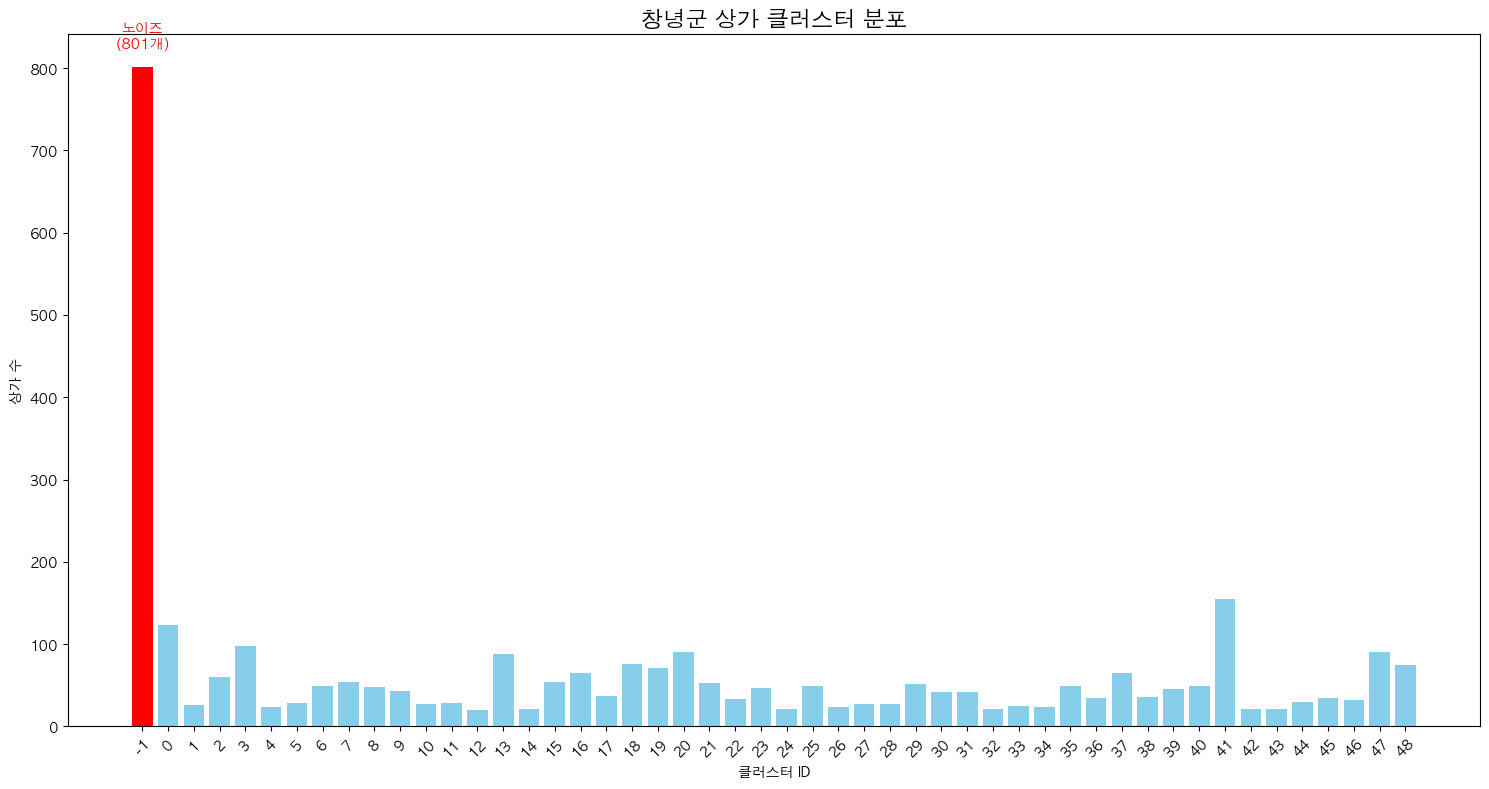

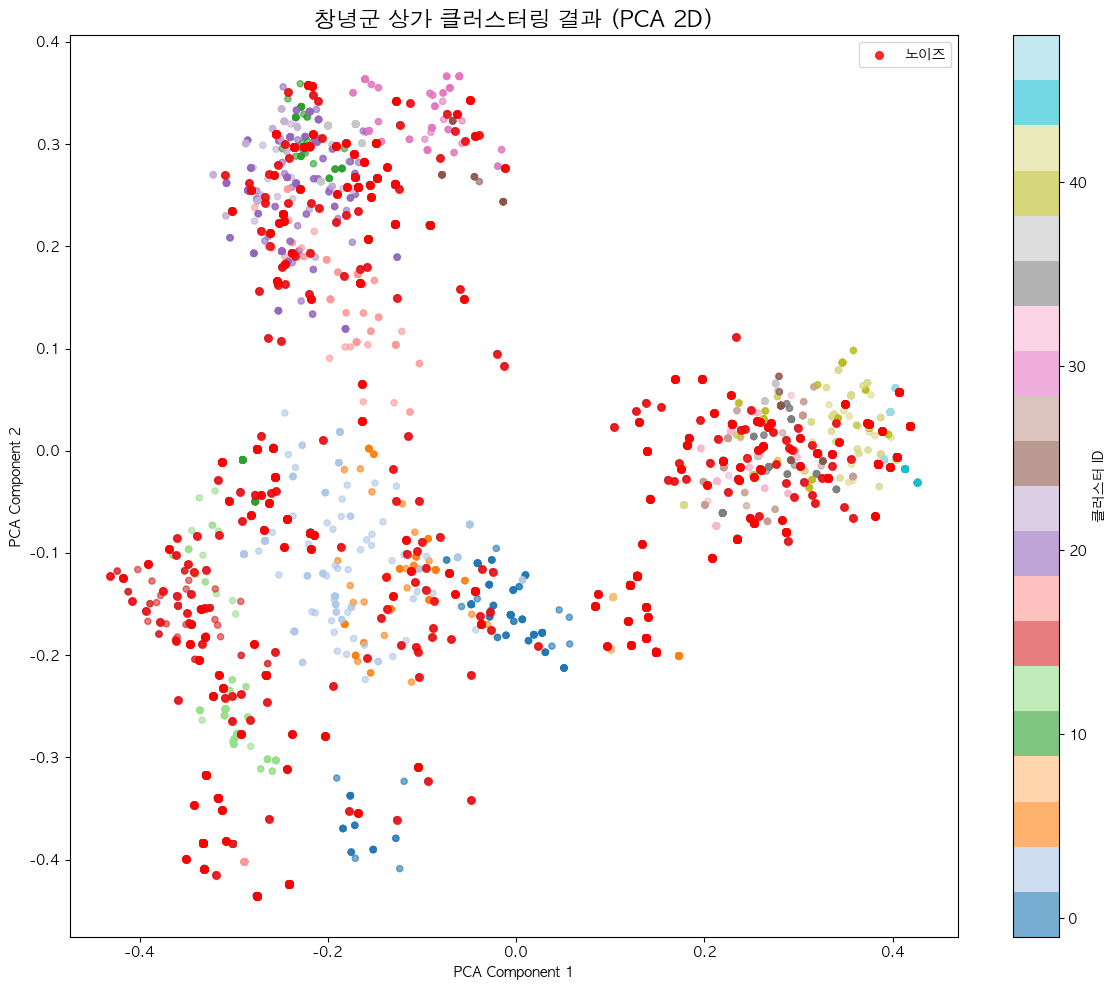

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# 한글 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'  # macOS용
plt.rcParams['axes.unicode_minus'] = False

# 1. 클러스터 분포 막대 그래프
plt.figure(figsize=(15, 8))
cluster_counts = df['cluster'].value_counts().sort_index()
colors = ['red' if x == -1 else 'skyblue' for x in cluster_counts.index]

plt.bar(range(len(cluster_counts)), cluster_counts.values, color=colors)
plt.title(f'{cityname} 상가 클러스터 분포', fontsize=16, fontweight='bold')
plt.xlabel('클러스터 ID')
plt.ylabel('상가 수')
plt.xticks(range(len(cluster_counts)), cluster_counts.index, rotation=45)

# 노이즈 클러스터(-1) 강조
plt.text(0, cluster_counts.iloc[0] + 20, f'노이즈\n({cluster_counts.iloc[0]}개)', 
         ha='center', va='bottom', fontweight='bold', color='red')

plt.tight_layout()
plt.show()

# 2. PCA로 2D 시각화
pca = PCA(n_components=2)
emb_2d = pca.fit_transform(emb)

plt.figure(figsize=(12, 10))
scatter = plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=df['cluster'], 
                     cmap='tab20', alpha=0.6, s=20)

# 노이즈 포인트(-1)는 빨간색으로 강조
noise_mask = df['cluster'] == -1
plt.scatter(emb_2d[noise_mask, 0], emb_2d[noise_mask, 1], 
           c='red', alpha=0.8, s=30, label='노이즈')

plt.title(f'{cityname} 상가 클러스터링 결과 (PCA 2D)', fontsize=16, fontweight='bold')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.colorbar(scatter, label='클러스터 ID')
plt.tight_layout()
plt.show()

In [9]:
# 노이즈 상세 분석
cluster_13_data = df[df['cluster'] == -1]

print("=== 노이즈 상세 분석 ===")
print(f"총 상가 수: {len(cluster_13_data)}개")
print(f"전체 대비 비율: {len(cluster_13_data)/len(df)*100:.1f}%")

print("\n1. 업종별 분포:")
print(cluster_13_data['상권업종대분류명'].value_counts())
print("\n   중분류별 분포:")
print(cluster_13_data['상권업종중분류명'].value_counts().head(10))

print("\n2. 지역별 분포:")
print(cluster_13_data['행정동명'].value_counts())

print("\n3. 상세 업종별 분포 (상위 15개):")
print(cluster_13_data['상권업종소분류명'].value_counts().head(15))

print("\n4. 노이즈의 상가 샘플 (처음 10개):")
print("-" * 80)
for idx, row in cluster_13_data.head(10).iterrows():
    print(f"• {row['행정동명']} - {row['상권업종대분류명']} > {row['상권업종중분류명']} > {row['상권업종소분류명']}")
    print(f"  주소: {row['지번주소']}")
    print()

=== 노이즈 상세 분석 ===
총 상가 수: 801개
전체 대비 비율: 25.4%

1. 업종별 분포:
상권업종대분류명
음식         329
소매         195
수리·개인      110
시설관리·임대     52
부동산         51
과학·기술       27
보건의료        21
예술·스포츠      13
교육           3
Name: count, dtype: int64

   중분류별 분포:
상권업종중분류명
비알코올          90
한식            88
종합 소매         69
이용·미용         63
기타 간이         52
부동산 서비스       51
주점            36
청소·방제         25
기타 생활용품 소매    20
식료품 소매        20
Name: count, dtype: int64

2. 지역별 분포:
행정동명
창녕읍    168
영산면    119
남지읍     93
부곡면     80
계성면     70
대합면     58
이방면     49
대지면     39
도천면     30
성산면     24
고암면     22
길곡면     22
유어면     16
장마면     11
Name: count, dtype: int64

3. 상세 업종별 분포 (상위 15개):
상권업종소분류명
카페               90
백반/한정식           63
부동산 중개/대리업       51
슈퍼마켓             42
미용실              32
치킨               28
편의점              27
피부 관리실           17
건축물 일반 청소업       16
구내식당             16
세탁소              15
일반 유흥 주점         15
그 외 기타 간이 음식점    14
네일숍              14
주방/가정용품 소매업      13
Name: count, dtype: int

In [10]:
# 노이즈 줄이기 위한 HDBSCAN 파라미터 조정 (지원되는 메트릭만 사용)
import hdbscan, joblib, numpy as np

print("=== 노이즈 줄이기 실험 ===")

# 실험 1: 더 관대한 파라미터 (euclidean)
print("\n1. 더 관대한 파라미터로 재실험")
clusterer_1 = hdbscan.HDBSCAN(
    metric="euclidean",
    min_cluster_size=10,      # 20 → 10으로 줄임
    min_samples=5,            # 10 → 5로 줄임
    prediction_data=True,
    cluster_selection_epsilon=0.5,  # 0.3 → 0.5로 증가
    alpha=1.0
).fit(emb)

labels_1 = clusterer_1.labels_
noise_count_1 = len(labels_1[labels_1 == -1])
print(f"노이즈 수: {noise_count_1}개 ({noise_count_1/len(df)*100:.1f}%)")
print(f"클러스터 수: {len(set(labels_1)) - (1 if -1 in labels_1 else 0)}개")

# 실험 2: 가장 관대한 파라미터
print("\n2. 가장 관대한 파라미터로 재실험")
clusterer_2 = hdbscan.HDBSCAN(
    metric="euclidean",
    min_cluster_size=5,       # 최소 클러스터 크기를 5로
    min_samples=3,            # 최소 샘플 수를 3으로
    prediction_data=True,
    cluster_selection_epsilon=0.6,  # 임계값을 0.6으로
    alpha=1.0
).fit(emb)

labels_2 = clusterer_2.labels_
noise_count_2 = len(labels_2[labels_2 == -1])
print(f"노이즈 수: {noise_count_2}개 ({noise_count_2/len(df)*100:.1f}%)")
print(f"클러스터 수: {len(set(labels_2)) - (1 if -1 in labels_2 else 0)}개")

=== 노이즈 줄이기 실험 ===

1. 더 관대한 파라미터로 재실험


/Users/leeyoungho/miniforge3/envs/ai_3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/leeyoungho/miniforge3/envs/ai_3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


노이즈 수: 81개 (2.6%)
클러스터 수: 32개

2. 가장 관대한 파라미터로 재실험


/Users/leeyoungho/miniforge3/envs/ai_3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/leeyoungho/miniforge3/envs/ai_3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


노이즈 수: 2개 (0.1%)
클러스터 수: 12개


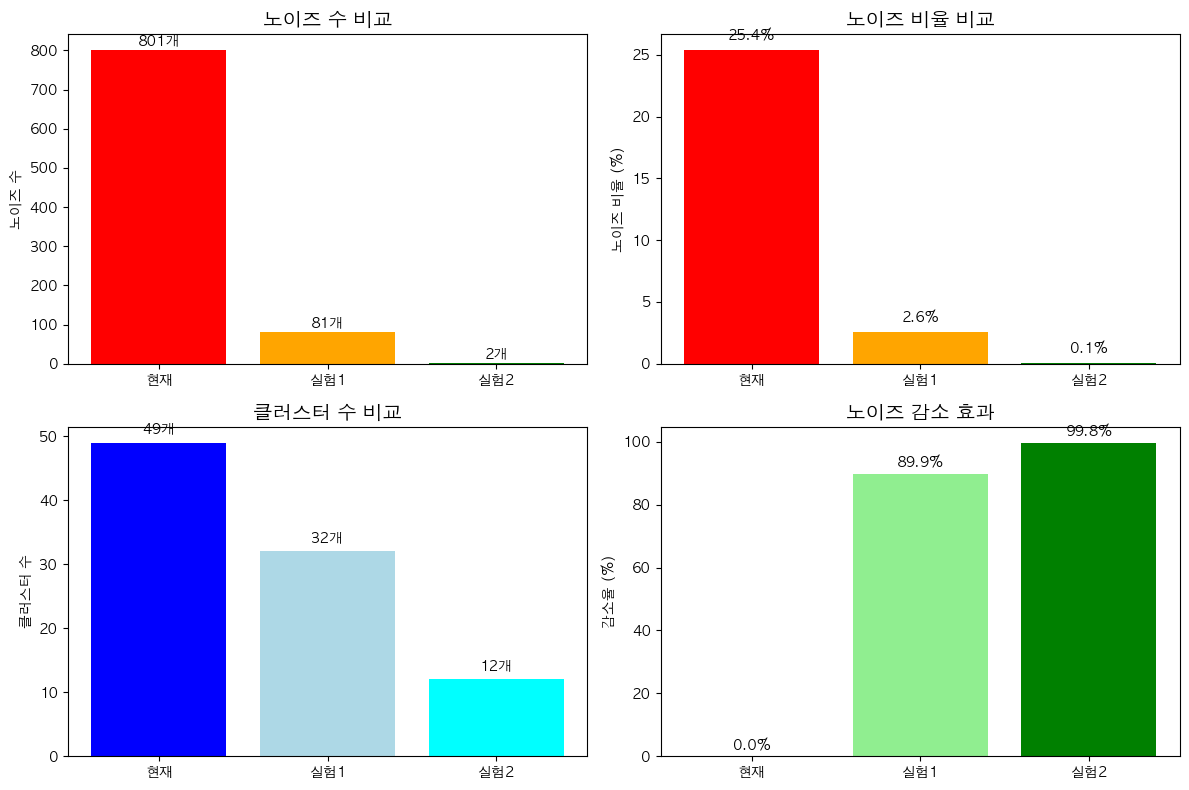

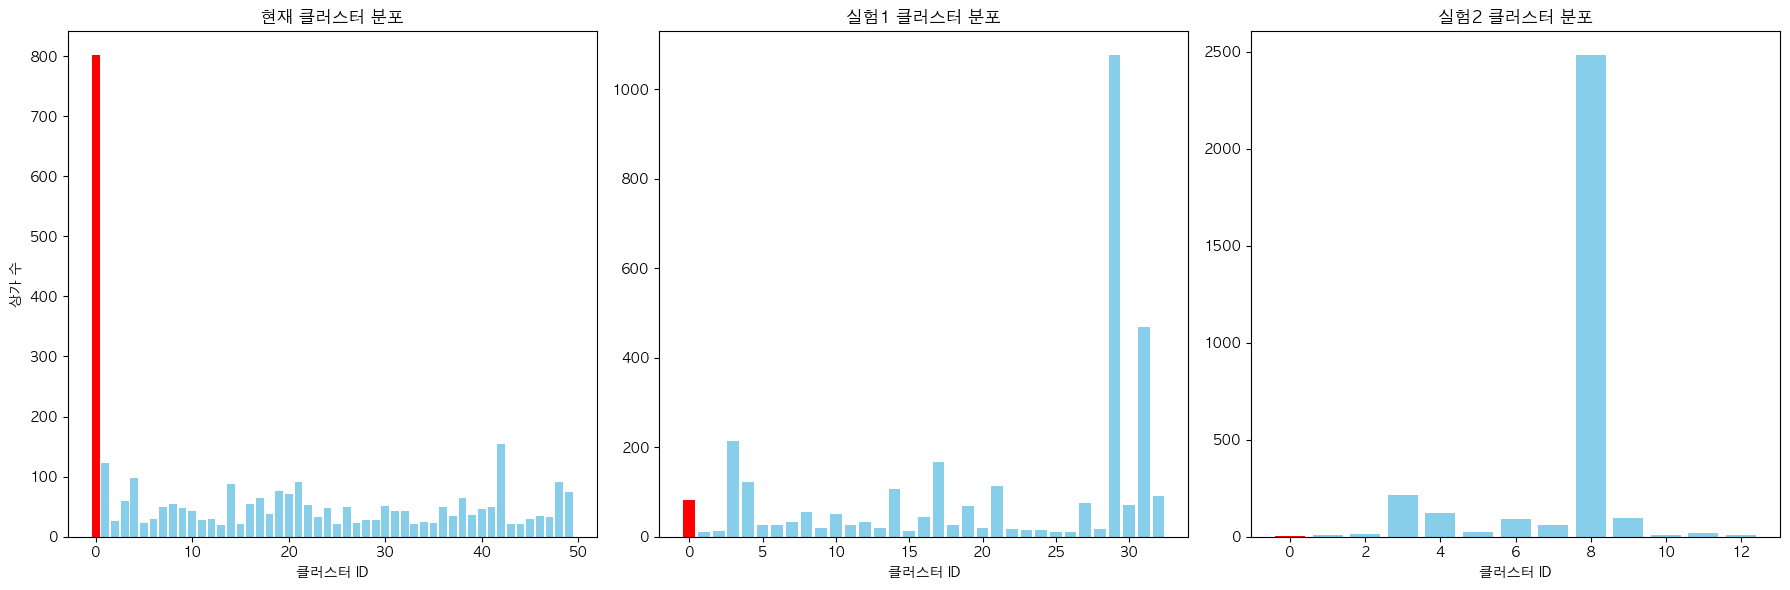

In [11]:
# 노이즈 줄이기 실험 결과 시각화
import matplotlib.pyplot as plt
import seaborn as sns

# 실험 결과 데이터 준비
experiment_names = ['현재', '실험1', '실험2']
noise_counts = [
    len(df[df['cluster'] == -1]),  # 현재
    noise_count_1,                 # 실험1
    noise_count_2                  # 실험2
]
cluster_counts = [
    len(set(df['cluster'])) - 1,   # 현재
    len(set(labels_1)) - (1 if -1 in labels_1 else 0),  # 실험1
    len(set(labels_2)) - (1 if -1 in labels_2 else 0)   # 실험2
]

# 1. 노이즈 수 비교 그래프
plt.figure(figsize=(12, 8))

# 서브플롯 1: 노이즈 수 비교
plt.subplot(2, 2, 1)
bars1 = plt.bar(experiment_names, noise_counts, color=['red', 'orange', 'green'])
plt.title('노이즈 수 비교', fontsize=14, fontweight='bold')
plt.ylabel('노이즈 수')
for bar, count in zip(bars1, noise_counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
             f'{count}개', ha='center', va='bottom', fontweight='bold')

# 서브플롯 2: 노이즈 비율 비교
plt.subplot(2, 2, 2)
noise_ratios = [count/len(df)*100 for count in noise_counts]
bars2 = plt.bar(experiment_names, noise_ratios, color=['red', 'orange', 'green'])
plt.title('노이즈 비율 비교', fontsize=14, fontweight='bold')
plt.ylabel('노이즈 비율 (%)')
for bar, ratio in zip(bars2, noise_ratios):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f'{ratio:.1f}%', ha='center', va='bottom', fontweight='bold')

# 서브플롯 3: 클러스터 수 비교
plt.subplot(2, 2, 3)
bars3 = plt.bar(experiment_names, cluster_counts, color=['blue', 'lightblue', 'cyan'])
plt.title('클러스터 수 비교', fontsize=14, fontweight='bold')
plt.ylabel('클러스터 수')
for bar, count in zip(bars3, cluster_counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{count}개', ha='center', va='bottom', fontweight='bold')

# 서브플롯 4: 개선 효과
plt.subplot(2, 2, 4)
improvement = [(noise_counts[0] - count)/noise_counts[0]*100 for count in noise_counts]
bars4 = plt.bar(experiment_names, improvement, color=['gray', 'lightgreen', 'green'])
plt.title('노이즈 감소 효과', fontsize=14, fontweight='bold')
plt.ylabel('감소율 (%)')
for bar, imp in zip(bars4, improvement):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{imp:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# 2. 실험별 클러스터 분포 비교
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 현재 클러스터 분포
current_clusters = df['cluster'].value_counts().sort_index()
axes[0].bar(range(len(current_clusters)), current_clusters.values, 
            color=['red' if x == -1 else 'skyblue' for x in current_clusters.index])
axes[0].set_title('현재 클러스터 분포', fontweight='bold')
axes[0].set_xlabel('클러스터 ID')
axes[0].set_ylabel('상가 수')

# 실험1 클러스터 분포
exp1_clusters = pd.Series(labels_1).value_counts().sort_index()
axes[1].bar(range(len(exp1_clusters)), exp1_clusters.values,
            color=['red' if x == -1 else 'skyblue' for x in exp1_clusters.index])
axes[1].set_title('실험1 클러스터 분포', fontweight='bold')
axes[1].set_xlabel('클러스터 ID')

# 실험2 클러스터 분포
exp2_clusters = pd.Series(labels_2).value_counts().sort_index()
axes[2].bar(range(len(exp2_clusters)), exp2_clusters.values,
            color=['red' if x == -1 else 'skyblue' for x in exp2_clusters.index])
axes[2].set_title('실험2 클러스터 분포', fontweight='bold')
axes[2].set_xlabel('클러스터 ID')

plt.tight_layout()
plt.show()

In [12]:
selected_result = '실험1'  # '현재', '실험1', '실험2' 중 선택

if selected_result == '실험1':
    df['cluster'] = labels_1
    clusterer = clusterer_1
elif selected_result == '실험2':
    df['cluster'] = labels_2
    clusterer = clusterer_2
# '현재'는 이미 반영되어 있음

print(f"\n[{selected_result}] 결과로 데이터프레임이 업데이트되었습니다.")
print(df['cluster'].value_counts().sort_index())


[실험1] 결과로 데이터프레임이 업데이트되었습니다.
cluster
-1       81
 0       10
 1       12
 2      215
 3      123
 4       26
 5       27
 6       33
 7       55
 8       19
 9       50
 10      27
 11      34
 12      19
 13     107
 14      12
 15      43
 16     166
 17      27
 18      69
 19      19
 20     113
 21      18
 22      14
 23      16
 24      10
 25      10
 26      76
 27      18
 28    1076
 29      71
 30     469
 31      91
Name: count, dtype: int64


In [13]:
print(f"\n=== {selected_result} 클러스터별 주요 업종/지역 분석 ===")
for cluster_id in sorted(df['cluster'].unique()):
    if cluster_id != -1:  # 노이즈 제외
        cluster_data = df[df['cluster'] == cluster_id]
        print(f"\n클러스터 {cluster_id} ({len(cluster_data)}개):")
        # 주요 업종 대분류
        major_business = cluster_data['상권업종대분류명'].value_counts().head(3)
        print(f"  주요 업종: {dict(major_business)}")
        # 주요 지역
        major_area = cluster_data['행정동명'].value_counts().head(3)
        print(f"  주요 지역: {dict(major_area)}")


=== 실험1 클러스터별 주요 업종/지역 분석 ===

클러스터 0 (10개):
  주요 업종: {'수리·개인': 10}
  주요 지역: {'창녕읍': 4, '남지읍': 3, '영산면': 2}

클러스터 1 (12개):
  주요 업종: {'과학·기술': 12}
  주요 지역: {'창녕읍': 6, '남지읍': 4, '영산면': 1}

클러스터 2 (215개):
  주요 업종: {'음식': 215}
  주요 지역: {'창녕읍': 54, '남지읍': 48, '영산면': 23}

클러스터 3 (123개):
  주요 업종: {'숙박': 123}
  주요 지역: {'부곡면': 33, '창녕읍': 19, '남지읍': 16}

클러스터 4 (26개):
  주요 업종: {'수리·개인': 26}
  주요 지역: {'창녕읍': 11, '남지읍': 6, '부곡면': 4}

클러스터 5 (27개):
  주요 업종: {'보건의료': 20, '과학·기술': 7}
  주요 지역: {'창녕읍': 13, '영산면': 4, '부곡면': 3}

클러스터 6 (33개):
  주요 업종: {'예술·스포츠': 33}
  주요 지역: {'창녕읍': 13, '남지읍': 10, '영산면': 3}

클러스터 7 (55개):
  주요 업종: {'예술·스포츠': 55}
  주요 지역: {'창녕읍': 19, '남지읍': 16, '대합면': 6}

클러스터 8 (19개):
  주요 업종: {'과학·기술': 19}
  주요 지역: {'창녕읍': 14, '남지읍': 3, '영산면': 1}

클러스터 9 (50개):
  주요 업종: {'과학·기술': 50}
  주요 지역: {'창녕읍': 36, '남지읍': 6, '길곡면': 3}

클러스터 10 (27개):
  주요 업종: {'과학·기술': 27}
  주요 지역: {'창녕읍': 15, '남지읍': 6, '대합면': 2}

클러스터 11 (34개):
  주요 업종: {'교육': 34}
  주요 지역: {'창녕읍': 20, '부곡면': 4, '남지읍': 4}

클러스터 1

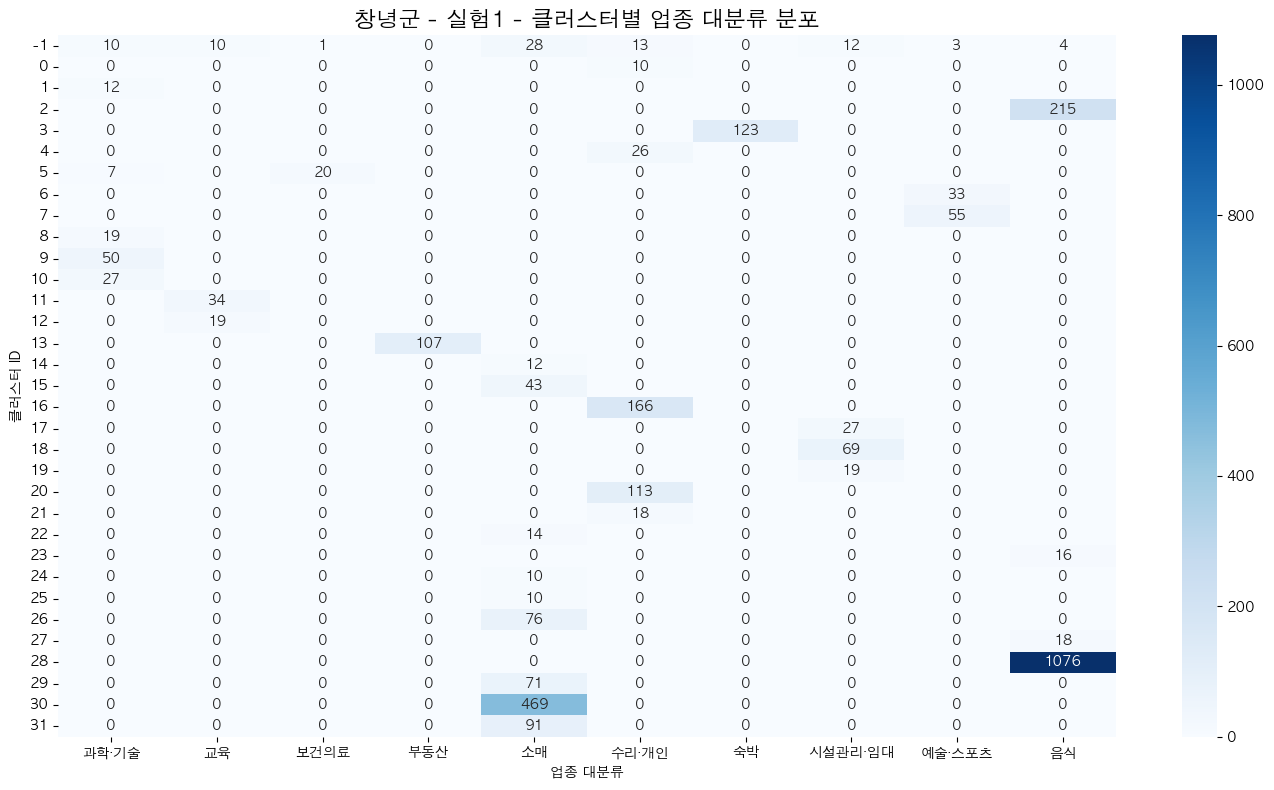

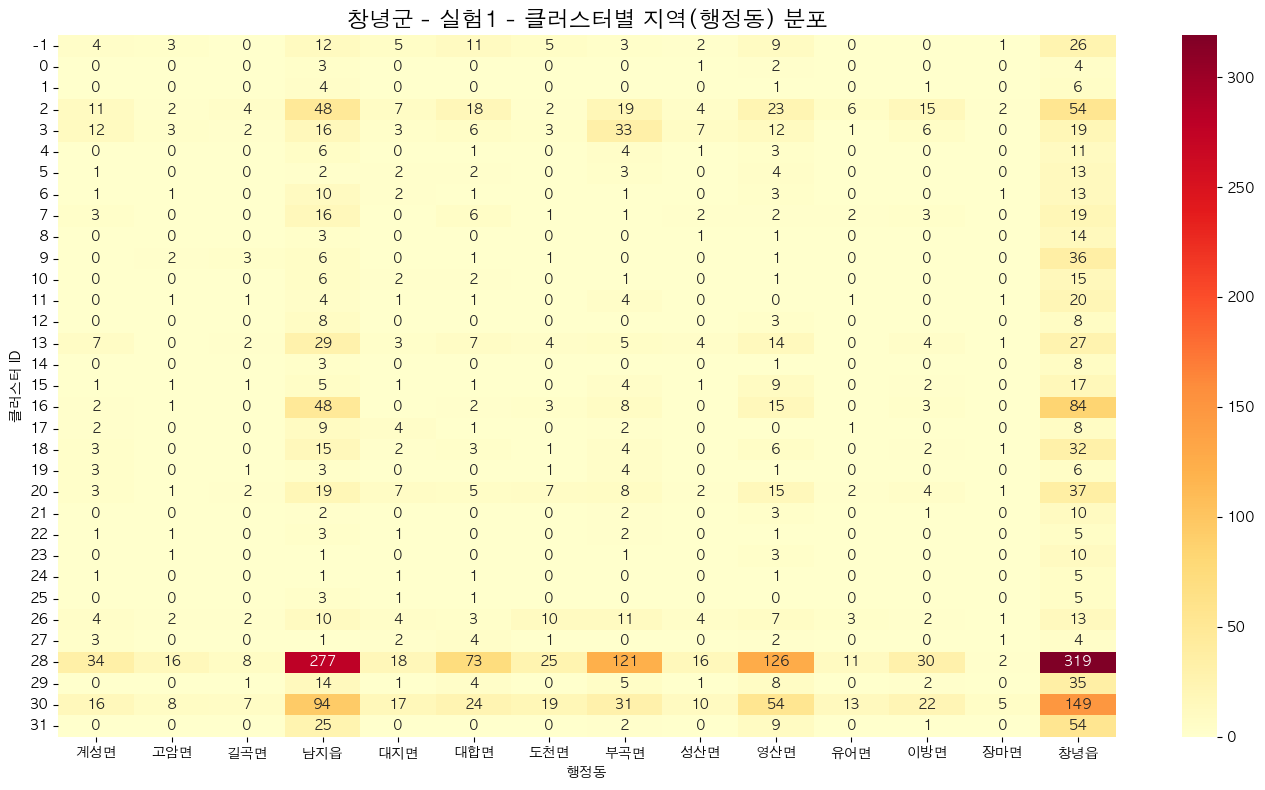

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# 클러스터별 업종 분포 히트맵
plt.figure(figsize=(14, 8))
cluster_business_pivot = pd.crosstab(df['cluster'], df['상권업종대분류명'])
sns.heatmap(cluster_business_pivot, annot=True, fmt='d', cmap='Blues')
plt.title(f'{cityname} - {selected_result} - 클러스터별 업종 대분류 분포', fontsize=16, fontweight='bold')
plt.xlabel('업종 대분류')
plt.ylabel('클러스터 ID')
plt.tight_layout()
plt.show()

# 클러스터별 지역 분포 히트맵
plt.figure(figsize=(14, 8))
cluster_area_pivot = pd.crosstab(df['cluster'], df['행정동명'])
sns.heatmap(cluster_area_pivot, annot=True, fmt='d', cmap='YlOrRd')
plt.title(f'{cityname} - {selected_result} - 클러스터별 지역(행정동) 분포', fontsize=16, fontweight='bold')
plt.xlabel('행정동')
plt.ylabel('클러스터 ID')
plt.tight_layout()
plt.show()

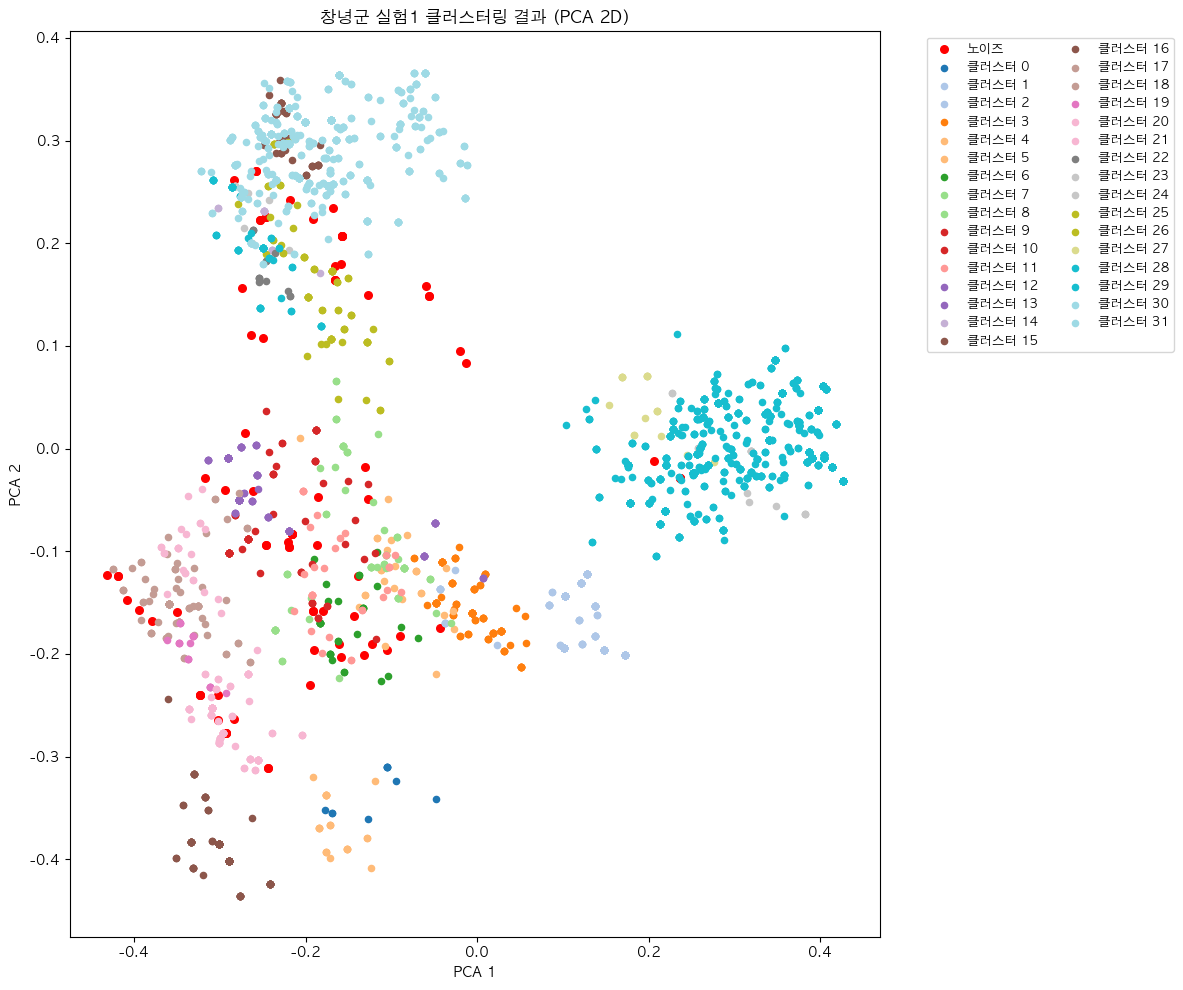

In [15]:
pca = PCA(n_components=2)
emb_2d = pca.fit_transform(emb)

plt.figure(figsize=(12, 10))
unique_clusters = np.unique(df['cluster'])
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_clusters)))

for i, cluster_id in enumerate(unique_clusters):
    mask = df['cluster'] == cluster_id
    if cluster_id == -1:
        plt.scatter(emb_2d[mask, 0], emb_2d[mask, 1], c='red', s=30, label='노이즈')
    else:
        plt.scatter(emb_2d[mask, 0], emb_2d[mask, 1], color=colors[i], s=20, label=f'클러스터 {cluster_id}')

plt.title(f'{cityname} 실험1 클러스터링 결과 (PCA 2D)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9, ncol=2)
plt.tight_layout()
plt.show()

In [27]:
# 클러스터링 결과가 포함된 원본 데이터프레임을 찾기
print("사용 가능한 변수들:")

# 현재 네임스페이스에서 데이터프레임 변수들을 찾기
import pandas as pd
import numpy as np

# 현재 변수들을 확인
current_vars = [var for var in dir() if not var.startswith('_')]
print("현재 변수들:", current_vars)

# 클러스터링 결과가 포함된 데이터프레임 찾기
df_cluster = None
for var_name in current_vars:
    try:
        var = eval(var_name)
        if isinstance(var, pd.DataFrame) and 'cluster' in var.columns:
            print(f"클러스터링 결과 발견: {var_name}")
            df_cluster = var
            break
    except:
        continue

# 클러스터별 의미있는 이름 생성
def get_cluster_name(cluster_id, df_cluster):
    """클러스터 ID를 기반으로 의미있는 이름을 생성"""
    if cluster_id == -1:
        return '노이즈'
    
    cluster_data = df_cluster[df_cluster['cluster'] == cluster_id]
    
    # 주요 업종 대분류
    major_business = cluster_data['상권업종대분류명'].value_counts().index[0]
    
    # 주요 업종 중분류 (상위 2개)
    major_sub_business = cluster_data['상권업종중분류명'].value_counts().head(2)
    
    # 클러스터 크기
    cluster_size = len(cluster_data)
    
    # 이름 생성 규칙
    if major_business == '소매':
        if '식료품' in major_sub_business.index[0]:
            return f'식료품소매 ({cluster_size}개)'
        elif '의류' in major_sub_business.index[0]:
            return f'의류소매 ({cluster_size}개)'
        else:
            return f'소매업 ({cluster_size}개)'
    elif major_business == '음식':
        if '한식' in major_sub_business.index[0]:
            return f'한식점 ({cluster_size}개)'
        elif '카페' in major_sub_business.index[0]:
            return f'카페 ({cluster_size}개)'
        else:
            return f'음식점 ({cluster_size}개)'
    elif major_business == '수리·개인':
        if '이용·미용' in major_sub_business.index[0]:
            return f'미용업 ({cluster_size}개)'
        else:
            return f'수리서비스 ({cluster_size}개)'
    elif major_business == '부동산':
        return f'부동산 ({cluster_size}개)'
    elif major_business == '교육':
        return f'교육업 ({cluster_size}개)'
    elif major_business == '보건의료':
        return f'의료업 ({cluster_size}개)'
    elif major_business == '숙박':
        return f'숙박업 ({cluster_size}개)'
    elif major_business == '과학·기술':
        return f'기술서비스 ({cluster_size}개)'
    elif major_business == '시설관리·임대':
        return f'시설관리 ({cluster_size}개)'
    elif major_business == '예술·스포츠':
        return f'문화스포츠 ({cluster_size}개)'
    else:
        return f'{major_business} ({cluster_size}개)'

# 클러스터링 결과가 포함된 데이터프레임을 찾았는지 확인
if df_cluster is not None:
    print(f"\n=== {cityname} 클러스터별 상세 정보 ===")
    unique_clusters = np.unique(df_cluster['cluster'])

    for cluster_id in sorted(unique_clusters):
        if cluster_id != -1:
            cluster_data = df_cluster[df_cluster['cluster'] == cluster_id]
            cluster_name = get_cluster_name(cluster_id, df_cluster)
            
            print(f"\n{cluster_name}:")
            
            # 주요 업종
            major_business = cluster_data['상권업종대분류명'].value_counts().head(3)
            print(f"  주요 업종: {dict(major_business)}")
            
            # 주요 중분류
            major_sub = cluster_data['상권업종중분류명'].value_counts().head(3)
            print(f"  주요 중분류: {dict(major_sub)}")
            
            # 주요 지역
            major_area = cluster_data['행정동명'].value_counts().head(3)
            print(f"  주요 지역: {dict(major_area)}")
            
            # 샘플 상가
            sample_business = cluster_data['상권업종소분류명'].value_counts().head(3)
            print(f"  대표 업종: {dict(sample_business)}")
        else:
            print(f"\n노이즈 ({len(df_cluster[df_cluster['cluster'] == -1])}개):")
            noise_data = df_cluster[df_cluster['cluster'] == -1]
            print(f"  주요 업종: {dict(noise_data['상권업종대분류명'].value_counts().head(3))}")

    # 클러스터 이름 매핑 딕셔너리 생성
    cluster_name_mapping = {}
    for cluster_id in unique_clusters:
        cluster_name_mapping[cluster_id] = get_cluster_name(cluster_id, df_cluster)

    print(f"\n=== 클러스터 이름 매핑 ===")
    for cluster_id, name in cluster_name_mapping.items():
        print(f"클러스터 {cluster_id} → {name}")
        
    # PCA 시각화도 업데이트
    pca = PCA(n_components=2)
    emb_2d = pca.fit_transform(emb)

    plt.figure(figsize=(14, 10))
    colors = plt.cm.tab20(np.linspace(0, 1, len(unique_clusters)))

    for i, cluster_id in enumerate(unique_clusters):
        mask = df_cluster['cluster'] == cluster_id
        cluster_name = get_cluster_name(cluster_id, df_cluster)
        
        if cluster_id == -1:
            plt.scatter(emb_2d[mask, 0], emb_2d[mask, 1], c='red', s=30, label=cluster_name)
        else:
            plt.scatter(emb_2d[mask, 0], emb_2d[mask, 1], color=colors[i], s=20, label=cluster_name)

    plt.title(f'{cityname} 실험1 클러스터링 결과 (PCA 2D)', fontsize=14, fontweight='bold')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, ncol=1)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
else:
    print("클러스터링 결과가 포함된 데이터프레임을 찾을 수 없습니다.")
    print("다음 중 하나를 시도해보세요:")
    print("1. 클러스터링 코드를 다시 실행")
    print("2. 클러스터링 결과가 저장된 변수명을 직접 지정")
    print("3. 원본 데이터를 다시 로드하여 클러스터링 수행")

사용 가능한 변수들:
현재 변수들: ['BATCH', 'In', 'MODEL_ID', 'Out', 'PCA', 'SentenceTransformer', 'age_columns', 'age_data', 'age_group', 'age_groups', 'axes', 'bar', 'bars', 'bars1', 'bars2', 'bars3', 'bars4', 'batch', 'city_counts', 'cityname', 'clean', 'cluster_13_data', 'cluster_area_pivot', 'cluster_business_pivot', 'cluster_counts', 'cluster_data', 'cluster_id', 'clusterer', 'clusterer_1', 'clusterer_2', 'col', 'col_name', 'colors', 'count', 'current_clusters', 'd', 'df', 'emb', 'emb_2d', 'emb_list', 'embedder', 'embs', 'exit', 'exp1_clusters', 'exp2_clusters', 'experiment_names', 'faiss', 'fig', 'find_similar', 'find_similar_with_details', 'get_cluster_name', 'get_ipython', 'hdbscan', 'i', 'idx', 'imp', 'improvement', 'index', 'joblib', 'labels_1', 'labels_2', 'major_area', 'major_business', 'mask', 'min_cluster', 'min_samples', 'n', 'noise_count_1', 'noise_count_2', 'noise_counts', 'noise_mask', 'noise_ratios', 'np', 'open', 'pca', 'pd', 'plt', 'pop', 'population', 'populations', 'quit', 'r

IndexError: boolean index did not match indexed array along dimension 0; dimension is 3156 but corresponding boolean dimension is 801

<Figure size 1400x1000 with 0 Axes>

_____

데이터 형태: (15, 46)
컬럼명: ['행정구역', '2020년_거주자_총인구수', '2020년_거주자_연령구간인구수', '2020년_거주자_0~9세', '2020년_남_거주자_총인구수', '2020년_남_거주자_연령구간인구수', '2020년_남_거주자_0~9세', '2020년_여_거주자_총인구수', '2020년_여_거주자_연령구간인구수', '2020년_여_거주자_0~9세']


NameError: name 'cityname' is not defined

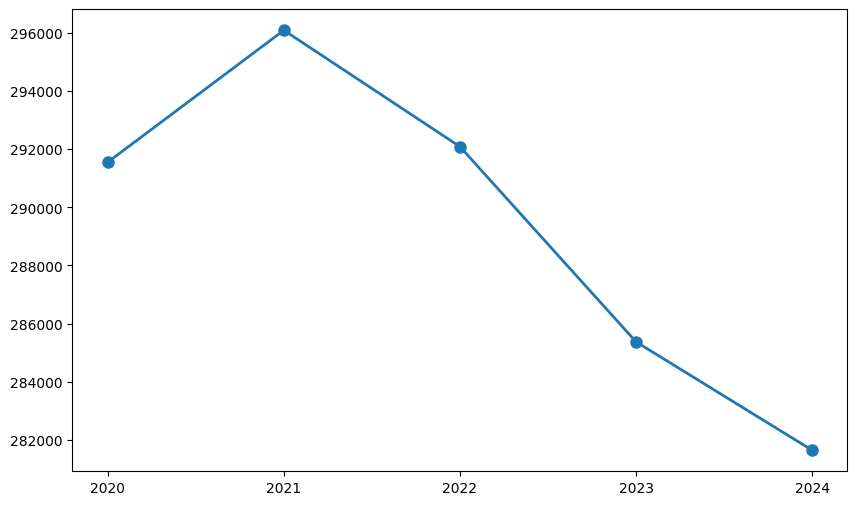

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 연간 인구 데이터 불러오기 (CP949 인코딩 사용)
df = pd.read_csv('./data/202012_202412_연령별인구현황_연간_포천시.csv', encoding='cp949')

# 데이터 구조 확인
print("데이터 형태:", df.shape)
print("컬럼명:", df.columns.tolist()[:10])  # 처음 10개만 출력

# 연도별 총인구수 추출 (2020-2024년)
years = ['2020', '2021', '2022', '2023', '2024']
total_population = []

for year in years:
    col_name = f'{year}년_거주자_총인구수'
    if col_name in df.columns:
        # 쉼표 제거하고 숫자로 변환
        population = df[col_name].astype(str).str.replace(',', '').astype(float).sum()
        total_population.append(population)

# 연도별 총인구수 시각화
plt.figure(figsize=(10, 6))
plt.plot(years, total_population, marker='o', linewidth=2, markersize=8)
plt.title(f'{cityname} - 연도별 총인구수 추이 (2020-2024)', fontsize=14, fontweight='bold')
plt.xlabel('연도')
plt.ylabel('총인구수')
plt.grid(True, alpha=0.3)

# 값 표시
for i, (year, pop) in enumerate(zip(years, total_population)):
    plt.text(i, pop + 1000, f'{pop:,.0f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# 연령대별 인구 분포 (2024년 기준)
age_columns = [col for col in df.columns if '2024년_거주자_' in col and '총인구수' not in col and '연령구간인구수' not in col]
age_data = []

for col in age_columns:
    age_group = col.replace('2024년_거주자_', '').replace('세', '세')
    # 문자열로 변환 후 쉼표 제거하고 숫자로 변환
    population = df[col].astype(str).str.replace(',', '').astype(float).sum()
    age_data.append((age_group, population))

# 연령대별 인구 분포 시각화
age_groups, populations = zip(*age_data)

plt.figure(figsize=(12, 6))
bars = plt.bar(age_groups, populations, color='skyblue', alpha=0.7)
plt.title(f'{cityname} - 2024년 연령대별 인구 분포', fontsize=14, fontweight='bold')
plt.xlabel('연령대')
plt.ylabel('인구수')
plt.tight_layout()
plt.show()

-----

여기부터는 .py 에서 진행

7. 새 글 추가 → 실시간 검색 + 인덱스 갱신

In [15]:
def add_idea(new_row: dict, search_k: int = 5):
    """
    새 아이디어 1건을
      1) 전처리·임베딩
      2) FAISS 검색 → 유사도 top-k 반환
      3) 인덱스·데이터프레임·임베딩 배열 업데이트
    """
    global emb, df, index

    # 1) 전처리 + 임베딩
    cleaned = clean(new_row["title"] + " " + new_row["body"])
    vec     = embedder.encode([cleaned], normalize_embeddings=True).astype("float32")

    # 2) 유사도 검색
    D, I = index.search(vec, search_k)
    similar = [(int(idx), float(score)) for idx, score in zip(I[0], D[0])]

    # 3-A) 인덱스·임베딩 배열 업데이트
    index.add(vec)                          # FAISS에 즉시 반영
    emb = np.vstack([emb, vec])             # ndarray 확장

    # 3-B) 데이터프레임 업데이트
    #     ★ 여기서 오류가 났던 부분 → 중괄호 개수 수정
    df = pd.concat(
        [df, pd.DataFrame([ new_row | {"clean": cleaned} ])],
        ignore_index=True
    )

    return similar

Note: HDBSCAN은 증분 학습이 불가하므로
cron or Airflow로 5분마다 전체 재빌드 (clusterer.fit(emb))를 돌리면 됩니다.

8. 프론트 연동 초간단 API

In [16]:
import sys
!{str(sys.executable)} -m pip install fastapi

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [17]:
from fastapi import FastAPI
app = FastAPI()

@app.post("/submit")
def submit(idea: dict):
    sim = add_idea(idea)
    # 코사인 0.7↑ + 같은 cluster 아이템만 추천
    recs = [idx for idx, sc in sim if sc > 0.7 and
            df.loc[idx, "cluster"] == df.iloc[-1]["cluster"]]
    return {"similar_ids": recs}

In [18]:
import sys
!{str(sys.executable)} -m pip install fastapi uvicorn pydantic[dotenv] requests

zsh:1: no matches found: pydantic[dotenv]


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
